## Project 3: Predicting Credit Card Default via Classification

### Declare and Import all Libraries and Packages used

In [ ]:
# Declare and import all packages
#from __future__          import absolute_import, division, print_function, unicode_literals
import pandas            as pd
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn           as sns
import tensorflow        as tf
#import keras

from sklearn.metrics         import accuracy_score, make_scorer, confusion_matrix, \
                                    precision_score, recall_score, \
                                    precision_recall_curve, \
                                    f1_score, fbeta_score, roc_curve, auc

from sklearn                 import metrics

from sklearn.model_selection import train_test_split,cross_val_score, \
                                    GridSearchCV, cross_validate

from sklearn.preprocessing   import StandardScaler 
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes     import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.ensemble        import RandomForestClassifier,ExtraTreesClassifier, \
                                    AdaBoostClassifier,GradientBoostingClassifier

from catboost                import CatBoostClassifier
from xgboost                 import XGBClassifier

from imblearn.over_sampling  import RandomOverSampler,SMOTE,ADASYN

from collections             import Counter

from sklearn.svm             import SVC
from sklearn                 import svm

from tensorflow.keras        import layers,Sequential
from tensorflow.keras.layers import Dense

#import multiprocessing
from yellowbrick.classifier  import DiscriminationThreshold

import altair as alt
#from vega_datasets import data
alt.renderers.enable('notebook')

%matplotlib inline 

#### Set Global Parameters
This values will be standard across all classifiers 

In [2]:
# Set global parameters
random_seed             = 42     # Random seed
sample_test_size        = 0.2    # 20% of sample size for testing
cv_value                = 10     # Cross validation number of folds

### Data Loading and Cleaning

#### Load Dataset

In [3]:
# Read in the data set
# Data set obtained from UCI Website
df = pd.read_csv('./data/data.csv')

#### Minor EDA

In [4]:
print(df.shape)

(30000, 25)


In [5]:
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

In [7]:
# Print out our columns
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [8]:
# Rename the column name of PAY_0 to PAY_1 and default payment next month to DEFAULT
df = df.rename(columns={'PAY_0':'PAY_1',
                        'default payment next month':'DEFAULT'})

df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [9]:
 # Let's take a look at the data more
df[['LIMIT_BAL']].describe()

,LIMIT_BAL
count,30000.000000
mean,167484.322667
std,129747.661567
min,10000.000000
25%,50000.000000
50%,140000.000000
75%,240000.000000
max,1000000.000000


In [10]:
df[['SEX','EDUCATION','MARRIAGE', 'AGE']].describe()

# From the data below, looks like data points for education and marriage are missing
# Note that the minimum for education and marriage are not zero

,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867,35.485500
std,0.489129,0.790349,0.521970,9.217904
min,1.000000,0.000000,0.000000,21.000000
25%,1.000000,1.000000,1.000000,28.000000
50%,2.000000,2.000000,2.000000,34.000000
75%,2.000000,2.000000,2.000000,41.000000
max,2.000000,6.000000,3.000000,79.000000


In [11]:
df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [12]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [13]:
df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [14]:
# Extract all our features
# Get the second column through the second last column
# The last column is the target vector
X_raw = df.iloc[:,1:-1]

# Extract the target vector which is where the client defaults on payment
y = df['DEFAULT']

In [15]:
print(X_raw.columns)
print(type(X_raw))
print(X_raw.shape)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
(30000, 23)


In [16]:
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(30000,)


In [17]:
# How many default and not default. Let's take a look
n_defaults  = y.sum()
nn_defaults = y.shape[0] - n_defaults

print('Total number of non-defaults =',nn_defaults)
print('Total number of defaults =',n_defaults)

print('Percentage of defaults =', y.sum()/len(y)*100,'%')

Total number of non-defaults = 23364
Total number of defaults = 6636
Percentage of defaults = 22.12 %


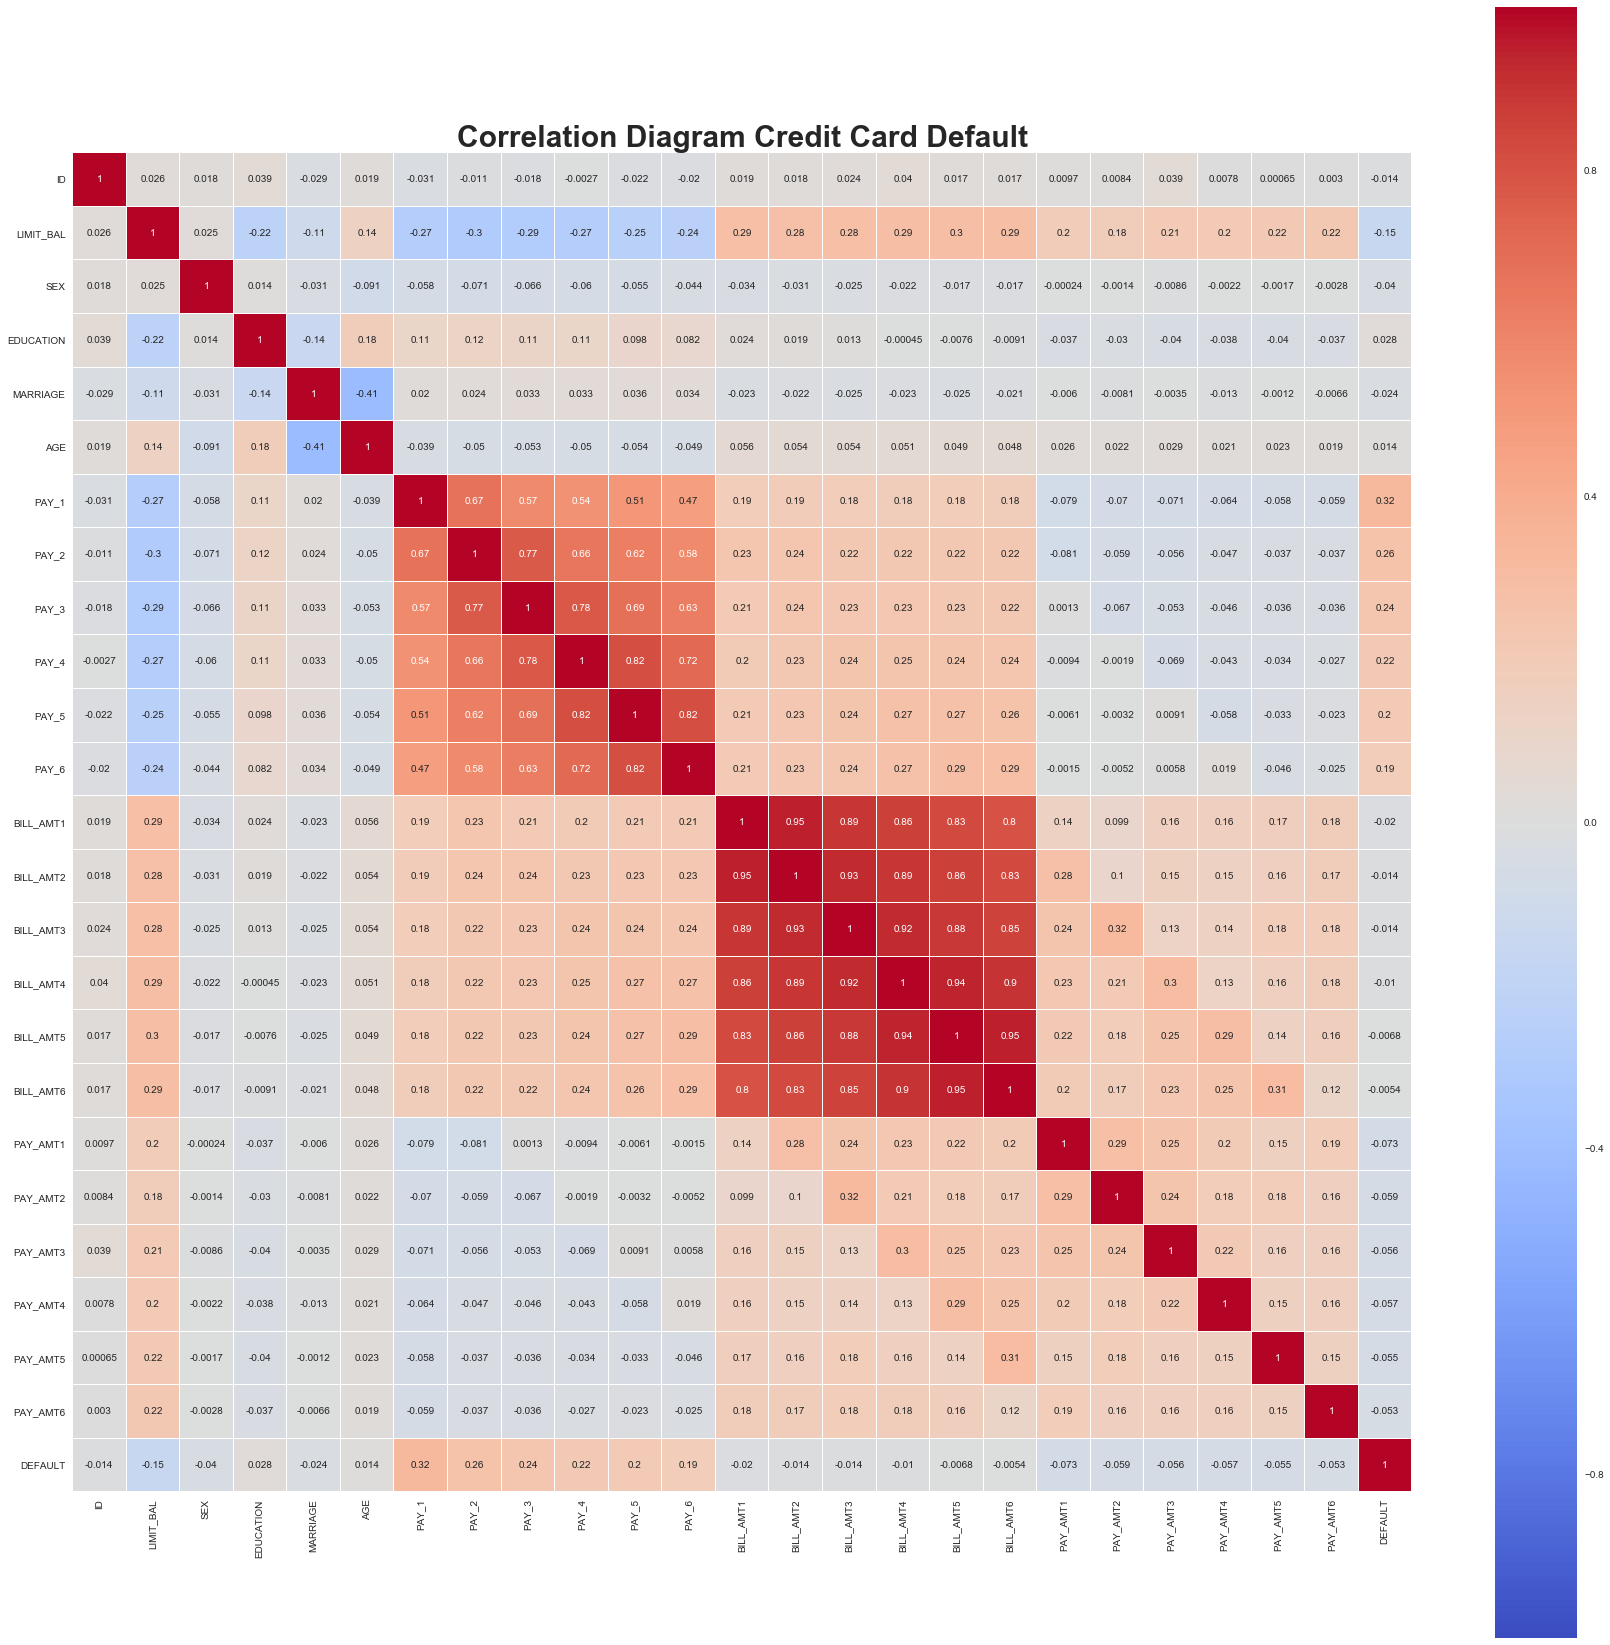

In [19]:
# Making correlation coefficients pair plot of all feature in order to identify degenrate features
# Minor modification from Mahyar M. Moghadam (Kaggle) which has awesome visuals
plt.figure(figsize=(30,30))
ax = plt.axes()
#corr = df.drop(['ID'], axis=1).corr()
correlation = df.corr()
sns.heatmap(correlation, vmax=1,vmin=-1, square=True, annot=True, cmap='coolwarm',linecolor="white", linewidths=0.01, ax=ax)
ax.set_title('Correlation Diagram Credit Card Default',fontweight="bold", size=30)
plt.savefig('corr_matrix.svg')
plt.show()

In [20]:
# Get those that defaulted
df_def = df[df['DEFAULT']==1];

#print(df_def.index);

In [21]:
# Now I need to get the total sum of losses from those that did default
df_def.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
13,14,70000,1,2,2,30,1,2,2,0,...,66782,36137,36894,3200,0,3000,3000,1500,0,1
16,17,20000,1,1,2,24,0,0,2,2,...,18338,17905,19104,3200,0,1500,0,1650,0,1
21,22,120000,2,2,1,39,-1,-1,-1,-1,...,0,632,316,316,316,0,632,316,0,1


#### Loss/Gain Specification and Details

##### Loss Due to Default

In [22]:
# Get total amount of losses due to defaults
df_def_bill_amnt = df_def[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]

list_bill_def_amt = df_def_bill_amnt.values.tolist()

#print(list_bill_def_amt)

# We want to the last bill balance that was not paid
def_amnt = []

counter = 0

for i_list_bill in list_bill_def_amt:
            
    #if (i_list_bill.count(0) < 6):
    #    imax = np.max(np.nonzero(i_list_bill))
    #    def_amnt.append(i_list_bill[imax])
    #else:
    #    def_amnt.append(0)
    def_amnt.append(i_list_bill[0])

#print(def_amnt)
#print(len(def_amnt))
#print(sum(def_amnt))

total_def_amnt = sum(def_amnt)

print ("Total losses of defaults: ${:12,.2f}".format(total_def_amnt))

avg_default_loss = float(total_def_amnt)/float(n_defaults)

print ("Average Default per Person: ${:12,.2f}".format(avg_default_loss))


Total losses of defaults: $321,906,801.00
Average Default per Person: $   48,509.16


##### Loss or Gain due to No Defaults

In [23]:
# Lets do the same for those who do NOT default
df_no_def = df[df['DEFAULT']==0]


In [94]:
df_no_def_bill_amnt = df_no_def[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]

list_bill_no_def_amt = df_no_def_bill_amnt.values.tolist()

# We want to the last bill balance that was not paid
no_def_amnt = []

for ii_list_bill in list_bill_no_def_amt:
        
    #if (ii_list_bill.count(0) < 6):
    #    iimax = np.max(np.nonzero(ii_list_bill))
    #    no_def_amnt.append(ii_list_bill[iimax])
    #else:
    #    no_def_amnt.append(0)
    
    # This should be summing up all balances and then
    # use it as revenue after APR is applied
    
    temp_sum = sum(ii_list_bill)   # Total up for the past six months
    
    no_def_amnt.append(temp_sum)
        
#print(no_def_amnt)
#print(sum(def_amnt))

#print(no_def_amnt)

total_no_def_balance = sum(no_def_amnt)

# We have to assume an Annual Percentage Rate
APR = 19.99   # This is in percent (Yes, very high)

monthly_APR = APR/365*30/100

print(monthly_APR)

avg_no_def_amnt_for_six_months = float(total_no_def_balance)/float(nn_defaults)

#print((1 + monthly_APR)**6)

#six_month_rev_apr = monthly_APR**6*avg_no_def_amnt
six_month_rev_apr = avg_no_def_amnt_for_six_months*( (1 + monthly_APR)**6 - 1) 

total_rev_from_interest_six_months = total_no_def_balance*( (1 + monthly_APR)**6 - 1 )
            
print ("Total account balance of non-defaults before APR: ${:12,.2f}".format(total_no_def_balance))

print ("Average revenue before APR: ${:12,.2f}".format(avg_no_def_amnt_for_six_months))

print("Total interest from non-defaults after APR: ${:12,.2f}".format(six_month_rev_apr))

#print("Monthly average APR Charge per account: ${:12,.2f}".format(six_month_rev_apr))
print("Total Revenue Collected from APR in six months: ${:12,.2f}".format(total_rev_from_interest_six_months))

print("Profit: ${:12,.2f}".format(total_rev_from_interest_six_months - total_def_amnt))

0.01643013698630137
Total account balance of non-defaults before APR: $6,365,029,003.00
Average revenue before APR: $  272,428.91
Total interest from non-defaults after APR: $   27,983.86
Total Revenue Collected from APR in six months: $653,814,947.57
Profit: $331,908,146.57


#### Split Raw Data into Train Test

In [31]:
# Train test split function
def get_train_test_split_data(X_in,y_in,test_sample_size,seed):
        
    X_tr, X_te, y_tr, y_te = train_test_split(X_in, y_in, test_size=test_sample_size, random_state=seed)
    
    return X_tr, X_te, y_tr, y_te

In [32]:
# Train test split on the raw data
X_train_raw, X_test_raw, y_train, y_test = get_train_test_split_data(X_raw, y, sample_test_size, random_seed)

In [33]:
n_defaults_test = y_test.sum()

print('Total number of defaults in test set =',n_defaults_test)

print('Percentage of defaults in test set =', y_test.sum()/len(y_test)*100,'%')

Total number of defaults in test set = 1313
Percentage of defaults in test set = 21.883333333333333 %


#### Feature Scaling

In [34]:
# Create a function to normalize via standard scalar
def scale_features(X_org):
    
    # Scale each column
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X_org)
    
    return (sc, X_scaled)

In [35]:
# Scale training and test set separately
scaler, X_train = scale_features(X_train_raw)

X_test = scaler.transform(X_test_raw)

print(type(X_train))
print(X_train.shape)
print(X_test.shape)
print(scaler)

<class 'numpy.ndarray'>
(24000, 23)
(6000, 23)
StandardScaler(copy=True, with_mean=True, with_std=True)


In [36]:
# Look at the index of the say y_test that are equal to 1
#print(y_test==1)
# So the global index is preserved after the train test split!

In [ ]:
# Not used but to get an idea of what the data looks like
'''Xdf = pd.DataFrame(X)
Xdf = pd.DataFrame(Xdf.values,columns=list(['LIMIT_BAL', 'SEX', 'EDUCATION', 
                                            'MARRIAGE', 'AGE', 
                                            'PAY_1', 'PAY_2','PAY_3', 'PAY_4', 
                                            'PAY_5', 'PAY_6', 'BILL_AMT1', 
                                            'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 
                                            'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                            'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
                                            'PAY_AMT5', 'PAY_AMT6']));

print(Xdf.shape)
Xdf.head(5)''';

### Machine Learning Classifiers

#### K-Nearest Neighbors

In [ ]:
# Let's train with 5 neighbors
#k_neighbors = 5

knn = KNeighborsClassifier(5)

knn.fit(X_train, y_train)

print("The score for kNN is\n")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

In [ ]:
# Let's make a prediction but for only 5 neighbours
y_pred_1 = knn.predict(X_test)

In [ ]:
print("K-NN Accuracy score  =",metrics.accuracy_score(y_test,y_pred_1))
print("K-NN Recall score    =",metrics.recall_score(y_test,y_pred_1))
print("K-NN Precision score =",metrics.precision_score(y_test,y_pred_1))
print("K-NN F1-score        =",metrics.f1_score(y_test,y_pred_1))

In [ ]:
# Print the confusion matrix
knn_confusion_matrix_temp = confusion_matrix(y_test, y_pred_1)
print("kNN confusion matrix: \n\n", knn_confusion_matrix_temp, '\n')

print('Total sum of kNN =',np.sum(knn_confusion_matrix_temp),'out of',n_defaults)

# There is something very wrong here. Total is 6,000 and the total defaults are 6,636
# What happened to the other 636?

In [ ]:
plt.figure(dpi=100)
sns.heatmap(knn_confusion_matrix_temp, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('kNN confusion matrix, credit card default');

In [ ]:
# Perhaps we should try different values of n_neighbours
k_range = range(1,31)

scores_dict_acc = {}
scores_dict_rec = {}
scores_dict_prec = {}
scores_dict_f1 = {}

scores_list_acc = []
scores_list_rec = []
scores_list_prec = []
scores_list_f1 = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    
    scores_dict_acc[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list_acc.append(metrics.accuracy_score(y_test,y_pred))
    
    scores_dict_rec[k] = metrics.recall_score(y_test,y_pred)
    scores_list_rec.append(metrics.recall_score(y_test,y_pred))
    
    scores_dict_prec[k] = metrics.precision_score(y_test,y_pred)
    scores_list_prec.append(metrics.precision_score(y_test,y_pred))
    
    scores_dict_f1[k] = metrics.f1_score(y_test,y_pred)
    scores_list_f1.append(metrics.f1_score(y_test,y_pred))





In [ ]:
#scores_dict_acc
#plot the relationship between K and the testing accuracy
plt.rc('font', size=12)
plt.figure(figsize=(16,9));
plt.plot(k_range,scores_list_acc,linewidth=2.5,label='KNN Accuracy');
plt.plot(k_range,scores_list_rec,linewidth=2.5,label='KNN Recall');
plt.plot(k_range,scores_list_prec,linewidth=2.5,label='KNN Precision');
plt.plot(k_range,scores_list_f1,linewidth=2.5,label='KNN F1');
plt.xlabel('Number of Neighbors, K, for KNN');
plt.ylabel('Testing Accuracy');
plt.grid();
plt.title('Testing Accuracy vs Num. Neighbors');
plt.legend(loc='best')
plt.savefig('knn_scores.svg')



# Based on the plot below the largest number in terms of accuracy appears to be 11 neighbours

In [ ]:
# Get the maximum value and the neighbour number that does it
#values.index(min(values))
optimum_k_num = scores_list_f1.index(max(scores_list_f1)) + 1
print('Optimum k number =',optimum_k_num)

In [ ]:
# Lets use 11 neighbours then to make a prediction
# Let's make a prediction but for only 11 neighbours
knn11 = KNeighborsClassifier(optimum_k_num)

knn11.fit(X_train, y_train)

print("The score for kNN is\n")
print("Training: {:6.2f}%".format(100*knn11.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn11.score(X_test, y_test)))

y_pred_11 = knn11.predict(X_test)

In [ ]:
# Print the confusion matrix
knn_confusion_matrix_11 = confusion_matrix(y_test, y_pred_11)

tn11, fp11, fn11, tp11 = confusion_matrix(y_test, y_pred_11).ravel()
print("True Negatives : ",tn11)
print("False Positives: ",fp11)
print("False Negatives: ",fn11)
print("True Positives : ",tp11,'\n')

print("kNN confusion matrix: \n\n", knn_confusion_matrix_11, '\n')

print('Total sum of kNN =',np.sum(knn_confusion_matrix_11),'out of',n_defaults)

plt.figure(dpi=100)
sns.heatmap(knn_confusion_matrix_11, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('kNN confusion matrix, credit card default, 11 Neighbours');
plt.savefig('kNN_confusion_matrix_k11.svg')

In [ ]:
# How about ROC curve
y_scores = knn11.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of kNN, k=11');
plt.grid();
plt.savefig('roc_curve_knn11.svg');
#plt.show();

In [ ]:
# using the default threshold of 0.5, which is what vanilla predict does
#print("Default threshold:")
#print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
#                                                     recall_score(y_test, y_predict)))

Still need to do gridsearchCV for more efficient parameter search

In [ ]:
# Cross Validation Loop
k_range = list(range(1, 51))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv = cv_value, scoring='roc_auc') # recall score
    #print('auc_score')
    k_scores.append(scores.mean())
    
#print(k_scores)

In [ ]:
plt.figure(figsize=(13,7));
plt.plot(k_range, k_scores, 'r' ,lw=2.5);
plt.xlabel('Value of K for KNN');
plt.ylabel('Cross-Validated ROC AUC');
plt.title('Cross-Validation ROC AUC, KNN')
plt.grid();

In [ ]:
# From the plot above looks like the best is k=30. 
# There are probably higher values but I would like
# to minimize the compute time
k_opt_cv = 30
knn30 = KNeighborsClassifier(k_opt_cv)

knn30.fit(X_train, y_train)

print("The score for kNN is\n")
print("Training: {:6.2f}%".format(100*knn30.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn30.score(X_test, y_test)))

y_pred_30 = knn30.predict(X_test)


In [ ]:
# Print the confusion matrix
knn_confusion_matrix_30 = confusion_matrix(y_test, y_pred_30)

tn30, fp30, fn30, tp30 = confusion_matrix(y_test, y_pred_30).ravel()
print("True Negatives : ",tn30)
print("False Positives: ",fp30)
print("False Negatives: ",fn30)
print("True Positives : ",tp30,'\n')

print("kNN confusion matrix: \n\n", knn_confusion_matrix_30, '\n')

print('Total sum of kNN =',np.sum(knn_confusion_matrix_30),'out of',n_defaults)

plt.figure(dpi=100)
sns.heatmap(knn_confusion_matrix_30, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('kNN confusion matrix, credit card default, 30 Neighbours');
plt.savefig('kNN_confusion_matrix_k30.svg')

In [ ]:
# Get AUC values for curve
y_scores_30 = knn30.predict_proba(X_test)

fpr30, tpr30, threshold30 = roc_curve(y_test, y_scores_30[:, 1])

roc_auc30 = auc(fpr30, tpr30)

f1_knn30 = f1_score(y_test,y_pred_30)
print(f1_knn30)

In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr30, tpr30, 'b', label = 'AUC = %0.2f' % roc_auc30,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of kNN, k=30');
plt.grid();
plt.savefig('roc_curve_knn30.svg');
#plt.show();

In [ ]:
# ROC curve
prc_curve, rec_curve, thr_curve = precision_recall_curve(y_test, y_scores_30[:,1])

plt.figure(figsize=(6,6));
plt.plot(thr_curve, prc_curve[1:], label='precision', lw = 3)
plt.plot(thr_curve, rec_curve[1:], label='recall', lw = 3)
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Default)');
plt.title('Precision and Recall Curves');
plt.grid();


In [ ]:
plt.figure(figsize=(6,6));
plt.plot(rec_curve[1:], prc_curve[1:],label='precision',lw=3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");
plt.grid();

In [ ]:
print("Default threshold: 0.5")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_pred_30), 
                                                     recall_score(y_test, y_pred_30)),'\n')


# With the plots above I want more Recall because I am getting too many False Negatives
#y_scores_30_threshold_gt0p2 = (y_scores_30[:,1] > 0.2)

#print("Threshold set to: 0.2")
#print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_scores_30_threshold_gt0p2), 
#                                                     recall_score(y_test, y_scores_30_threshold_gt0p2)))



In [ ]:
y_scores_30_threshold_ft0p2 = knn30.predict_proba(X_test)[:, 1] > 0.5

#fpr30n, tpr30n, threshold30n = roc_curve(y_test, y_scores_30_threshold_ft0p2[:, 1])

#roc_auc30n = auc(fpr30n, tpr30n)


# Print the confusion matrix
knn_confusion_matrix_30n = confusion_matrix(y_test, y_scores_30_threshold_ft0p2)

#tn30, fp30, fn30, tp30 = confusion_matrix(y_test, y_pred_30).ravel()
#print("True Negatives : ",tn30)
#print("False Positives: ",fp30)
#print("False Negatives: ",fn30)
#print("True Positives : ",tp30,'\n')

f1_knn30n = f1_score(y_test,y_scores_30_threshold_ft0p2)
print(f1_knn30n)

print("kNN confusion matrix: \n\n", knn_confusion_matrix_30n, '\n')

#print('Total sum of kNN =',np.sum(knn_confusion_matrix_30),'out of',n_defaults)

plt.figure(dpi=100)
sns.heatmap(knn_confusion_matrix_30n, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=[0,1],
            yticklabels=[0,1],fmt='g');

plt.xlabel('Predicted Defaults');
plt.ylabel('Actual Defaults');

#### Logistic Regression

In [ ]:
# Logistic Regression test
# Default value for C is 1
logres1 = LogisticRegression(C = 1,solver='lbfgs')

logres1.fit(X_train, y_train)

print("Logistic score, Train set: {:6.2f}%".format(100*logres1.score(X_train,y_train)))
print("Logistic score, Test set : {:6.2f}%".format(100*logres1.score(X_test, y_test)))

In [41]:
# Print the confusion matrix
# Make a prediction first on a default
def get_confusion_matrix(y_te,y_pr,n_def):

    model_confusion_matrix = confusion_matrix(y_te, y_pr);

    tn, fp, fn, tp = confusion_matrix(y_te, y_pr).ravel()

    print("True Negatives : ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives : ",tp,'\n')

    print("Confusion matrix: \n\n", model_confusion_matrix, '\n')

    #print('Sum of Classifier =',np.sum(model_confusion_matrix),'out of',n_def)
    
    return (tn,fp,fn,tp,model_confusion_matrix)

In [42]:
# Print the confusion matrix
# Make a prediction first on a default
def get_confusion_matrix_no_print(y_te,y_pr):

    model_confusion_matrix = confusion_matrix(y_te, y_pr);

    tn, fp, fn, tp = confusion_matrix(y_te, y_pr).ravel()

    #print("True Negatives : ",tn)
    #print("False Positives: ",fp)
    #print("False Negatives: ",fn)
    #print("True Positives : ",tp,'\n')

    #print("Confusion matrix: \n\n", model_confusion_matrix, '\n')

    #print('Sum of Classifier =',np.sum(model_confusion_matrix),'out of',n_def)
    
    return (tn,fp,fn,tp,model_confusion_matrix)

In [ ]:
y_pred_logres1 = logres1.predict(X_test)

tn,fp,fn,tp,logres1_confusion_matrix = get_confusion_matrix(y_test,y_pred_logres1,n_defaults)

plt.figure(dpi=100)
sns.heatmap(logres1_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('Logistic Regressions confusion matrix, credit card default, C=1');
plt.savefig('confusion_matrix_logres1.svg')

In [ ]:
# How about ROC curve
y_scores_logres1 = logres1.predict_proba(X_test)
fpr_logres1, tpr_logres1, threshold_logres1 = roc_curve(y_test, y_scores_logres1[:, 1])

roc_auc_logres1 = auc(fpr_logres1, tpr_logres1)
#print(threshold20)

In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_logres1, tpr_logres1, 'b', label = 'AUC = %0.2f' % roc_auc_logres1,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of Logistic Regression, C=1');
plt.grid();
plt.savefig('roc_curve_logres1.svg');
#plt.show();

In [ ]:
# See if we can find an optimum value of C
# Cross Validation Loop
C_range = []
for k in np.linspace(-5,0,101):
    C_range.append(10**(k))
    
#C_range = np.linspace(0.0)
C_scores = []

for i in C_range:
    logres = LogisticRegression(C = i,solver='lbfgs')
    scores = cross_val_score(logres, X_train, y_train, cv=cv_value, scoring='roc_auc')
    #print('auc_score')
    C_scores.append(scores.mean())
    
#print()

In [ ]:
plt.figure(figsize=(13,7));
plt.plot(C_range, C_scores, lw=2.5);
plt.xlabel('Value of C in Logistic Regression');
plt.ylabel('Cross-Validated ROC AUC');
plt.title('Cross-Validation ROC AUC, LogRes')
plt.grid();

In [ ]:
# Use Logistic Regression with Cross Validation
logregcv = LogisticRegressionCV(Cs=[1], cv=cv_value, random_state=random_seed)

logregcv.fit(X_train,y_train);

# How about ROC curve
y_scores_logregcv = logregcv.predict_proba(X_test)

fpr_logregcv, tpr_logregcv, threshold_logregcv = roc_curve(y_test, y_scores_logregcv[:, 1])

roc_auc_logregcv = auc(fpr_logregcv, tpr_logregcv)

print(roc_auc_logregcv)

So it looks like C = 1 is the optimum value for Logistic Regression which is not as great
compared to K-Nearest Neighbours

#### Naive Bayes

In [ ]:
# There are three types. Gaussian, Binomial and Multinomial
gnb = GaussianNB()
bnb = BernoulliNB()
#mnb = MultinomialNB()   <--- This did not work...complained about negative number

scores_gnb = cross_val_score(gnb, X_train, y_train, cv=cv_value, scoring='roc_auc')
scores_gnb.mean()

#print(scores_gnb.mean())

gnb.fit(X_train, y_train);
bnb.fit(X_train, y_train);
#mnb.fit(X_train, y_train);

y_pred_gnb = gnb.predict(X_test);
y_pred_bnb = bnb.predict(X_test);
#y_pred_mnb = mnb.predict(X_test);

In [ ]:
# ROC curve
y_scores_gnb = gnb.predict_proba(X_test)
y_scores_bnb = bnb.predict_proba(X_test)

fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(y_test, y_scores_gnb[:, 1])
fpr_bnb, tpr_bnb, threshold_bnb = roc_curve(y_test, y_scores_bnb[:, 1])

roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)


In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_gnb, tpr_gnb, 'b', label = 'AUC = %0.2f' % roc_auc_gnb,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of Naive Bayes Gaussian');
plt.grid();
plt.savefig('roc_curve_gnb.svg');
#plt.show();

#### Support Vector Machines (SVM)

In [ ]:
# Start with the standard Linear SVM
svc1 = svm.SVC(kernel='linear',probability=True);
svc1.fit(X_train,y_train);

print("SVC-Linear score, Train set: {:6.2f}%".format(100*svc1.score(X_train,y_train)))
print("SVC-Linear score, Test set : {:6.2f}%".format(100*svc1.score(X_test, y_test)))

In [ ]:
svc2 = svm.SVC(kernel='poly',probability=True);
svc2.fit(X_train,y_train);

print("SVC-Poly score, Train set: {:6.2f}%".format(100*svc2.score(X_train,y_train)))
print("SVC-Poly score, Test set : {:6.2f}%".format(100*svc2.score(X_test, y_test)))

In [ ]:
svc3 = svm.SVC(kernel='rbf',probability=True, C = 1);
svc3.fit(X_train,y_train);

print("SVC-RBF score, Train set: {:6.2f}%".format(100*svc3.score(X_train,y_train)))
print("SVC-RBF score, Test set : {:6.2f}%".format(100*svc3.score(X_test, y_test)))

In [ ]:
# ROC curve
y_scores_svc1 = svc1.predict_proba(X_test)
y_scores_svc2 = svc2.predict_proba(X_test)
y_scores_svc3 = svc3.predict_proba(X_test)

fpr_svc1, tpr_svc1, threshold_svc1 = roc_curve(y_test, y_scores_svc1[:, 1])
fpr_svc2, tpr_svc2, threshold_svc2 = roc_curve(y_test, y_scores_svc2[:, 1])
fpr_svc3, tpr_svc3, threshold_svc3 = roc_curve(y_test, y_scores_svc3[:, 1])

roc_auc_svc1 = auc(fpr_svc1, tpr_svc1)
roc_auc_svc2 = auc(fpr_svc2, tpr_svc2)
roc_auc_svc3 = auc(fpr_svc3, tpr_svc3)

print('AUC SVC-Linear Default    :',roc_auc_svc1)
print('AUC SVC-Polynomial Default:',roc_auc_svc2)
print('AUC SVC-RBF Default       :',roc_auc_svc3)

In [ ]:
y_pred_svc3 = svc3.predict(X_test)

tn_svc3,fp_svc3,fn_svc3,tp_svc3,svc3_confusion_matrix = get_confusion_matrix(y_test,y_pred_svc3,n_defaults)

plt.figure(dpi=100)
sns.heatmap(svc3_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('SVC-RBF confusion matrix, credit card default, C = 1');
plt.savefig('confusion_matrix_svc3.svg')

In [ ]:
# Cross Validation Loop
#svcl_range = [0.1,1,10,100,1000]
#svcl_range = [0.1,10,100]
#svcl_range = [10]

#for k in np.arange(1,,2):
#    svcl_range.append(10**(k))

#svcl_scores = []

#print(svcl_range)

#for k in svcl_range:
#    svcl = svm.SVC(kernel='linear',C = k);
#    scores = cross_val_score(svcl, X_train, y_train, cv=cv_value, scoring='roc_auc')
#    #print('auc_score')
#    svcl_scores.append(scores.mean())
#    print('C =',k,' Done!')
#    print('Scores =',scores)
    
#print(svcl_scores)
# C = 0.1, score = 0.7006495007799197
# C = 1,   score = 0.6962224119783551
# C = 10,  score = 
# C = 100, score =

#### Random Forest

In [ ]:
# See if we can find an optimum value of C
# Cross Validation Loop
s_estimators = 50;
e_estimators = 400;
n_incr = 50

N_range = np.arange(s_estimators,e_estimators+1,n_incr)

print(N_range)
    
#C_range = np.linspace(0.0)
RF_scores = []

for i in N_range:
    RFC = RandomForestClassifier(n_estimators=i,n_jobs=-1,random_state=random_seed)
    scores = cross_val_score(RFC, X_train_raw, y_train, cv=cv_value, scoring='roc_auc')
    #print('auc_score')
    RF_scores.append(scores.mean())
    
print(RF_scores)

In [ ]:
plt.figure(figsize=(13,7));
plt.plot(N_range, RF_scores, lw=2.5);
plt.xlabel('AUC vs Number of Estimators, Random Forest');
plt.ylabel('Cross-Validated ROC AUC');
plt.title('Cross-Validation ROC AUC, Random Forest')
plt.grid();

In [ ]:
n_forest_estimators = 400

randomforest = RandomForestClassifier(n_estimators=n_forest_estimators,n_jobs=-1,random_state=random_seed,max_features='auto')

randomforest.fit(X_train_raw, y_train);

print("Random Forest score, Train set: {:6.2f}%".format(100*randomforest.score(X_train,y_train)))
print("Random Forest score, Test set : {:6.2f}%".format(100*randomforest.score(X_test, y_test)))

y_pred_rf   = randomforest.predict(X_test_raw)
y_scores_rf = randomforest.predict_proba(X_test_raw)

In [ ]:
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_scores_rf[:, 1])

roc_auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC = %0.2f' % roc_auc_rf,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of Random Forest, n=400');
plt.grid();
plt.savefig('roc_curve_rf400.svg');
#plt.show();

In [ ]:
tn_rf,fp_rf,fn_rf,tp_rf,rf_confusion_matrix = get_confusion_matrix(y_test,y_pred_rf,n_defaults)

plt.figure(dpi=100)
sns.heatmap(rf_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('Random Forest confusion matrix, credit card default, n=400');
plt.savefig('confusion_matrix_rf400.svg')

#### Extra Random Trees

In [ ]:
# Start with the standard Linear SVM
etc1 = ExtraTreesClassifier(n_estimators=400,n_jobs=-1,random_state=random_seed,criterion ='entropy')
#ada_model = ensemble.AdaBoostClassifier()
etc1.fit(X_train_raw,y_train);

print("Extra Trees score, Train set: {:6.2f}%".format(100*etc1.score(X_train_raw,y_train)))
print("Extra Trees score, Test set : {:6.2f}%".format(100*etc1.score(X_test_raw, y_test)))

y_pred_etc1 = etc1.predict(X_test_raw)

y_scores_etc1 = etc1.predict_proba(X_test_raw)

In [ ]:
fpr_etc, tpr_etc, threshold_etc = roc_curve(y_test, y_scores_etc1[:, 1])

roc_auc_etc = auc(fpr_etc, tpr_etc)

print(roc_auc_etc)

In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_etc, tpr_etc, 'b', label = 'AUC = %0.2f' % roc_auc_etc,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of Extra Trees, n=300');
plt.grid();
plt.savefig('roc_curve_etc300.svg');
#plt.show();

In [ ]:
tn_etc,fp_etc,fn_etc,tp_etc,etc_confusion_matrix = get_confusion_matrix(y_test,y_pred_etc1,n_defaults)

plt.figure(dpi=100)
sns.heatmap(etc_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('Extra Trees confusion matrix, credit card default, n=300');
plt.savefig('confusion_matrix_etc300.svg')

#### ADABoost Classifier (Adaptive Boosting) with Random Forest

In [ ]:
# Create adaboost classifer object
# Boost default is a Decision Tree
#svc_basis = SVC(probability=True, kernel='rbf')
basis = RandomForestClassifier(n_estimators=400,n_jobs=-1)
#basis = LogisticRegression(C = 1,solver='lbfgs')
#abc = AdaBoostClassifier(n_estimators=400)

abc = AdaBoostClassifier(learning_rate=1,random_state=random_seed,base_estimator=basis)

# Train Adaboost Classifer
abc.fit(X_train, y_train)

print("ADA Boost score, Train set: {:6.2f}%".format(100*abc.score(X_train,y_train)))
print("ADA Boost score, Test set : {:6.2f}%".format(100*abc.score(X_test, y_test)))

In [ ]:
#Predict the response for test dataset
y_pred_abc = abc.predict(X_test)

y_scores_abc = abc.predict_proba(X_test)

In [ ]:
fpr_abc, tpr_abc, threshold_abc = roc_curve(y_test, y_scores_abc[:, 1])

roc_auc_abc = auc(fpr_abc, tpr_abc)

print(roc_auc_abc)

In [ ]:
tn_abc,fp_abc,fn_abc,tp_abc,abc_confusion_matrix = get_confusion_matrix(y_test,y_pred_abc,n_defaults)

plt.figure(dpi=100)
sns.heatmap(abc_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('ADA Boost confusion matrix, credit card default, n=400');
plt.savefig('confusion_matrix_abc300.svg')

#### CatBoost Classifier

In [ ]:
cat = CatBoostClassifier(iterations=1000,logging_level='Silent',learning_rate=0.01);
cat.fit(X_train,y_train);

In [ ]:
print("CatBoost score, Train set: {:6.2f}%".format(100*cat.score(X_train,y_train)))
print("CatBoost score, Test set : {:6.2f}%".format(100*cat.score(X_test, y_test)))

In [ ]:
#Predict the response for test dataset
y_pred_cat   = cat.predict(X_test)

y_scores_cat = cat.predict_proba(X_test)

fpr_cat, tpr_cat, threshold_cat = roc_curve(y_test, y_scores_cat[:, 1])

roc_auc_cat = auc(fpr_cat, tpr_cat)

print(roc_auc_cat)

In [ ]:
tn_cat,fp_cat,fn_cat,tp_cat,cat_confusion_matrix = get_confusion_matrix(y_test,y_pred_cat,n_defaults)

plt.figure(dpi=100)
sns.heatmap(cat_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('CatBoost confusion matrix, credit card default');
plt.savefig('confusion_matrix_cat_it1000.svg')

In [ ]:
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_cat, tpr_cat, 'b', label = 'AUC = %0.2f' % roc_auc_cat,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of CatBoost');
plt.grid();
plt.savefig('roc_curve_catboost.svg');
#plt.show();

#### Gradient Boosting

In [37]:
GB = GradientBoostingClassifier(n_estimators=400)

GB.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
#accuracy_score(y_test, y_pred)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [38]:
print("GradBoost score, Train set: {:6.2f}%".format(100*GB.score(X_train,y_train)))
print("GradBoost score, Test set : {:6.2f}%".format(100*GB.score(X_test, y_test)))

#y_pred_GB = GB.predict(X_test)
#accuracy_score(y_test, y_pred)

GradBoost score, Train set:  83.70%
GradBoost score, Test set :  81.97%


In [39]:
#Predict the response for test dataset
y_pred_GB   = GB.predict(X_test)

y_scores_GB = GB.predict_proba(X_test)

fpr_GB, tpr_GB, threshold_GB = roc_curve(y_test, y_scores_GB[:, 1])

roc_auc_GB = auc(fpr_GB, tpr_GB)

print(roc_auc_GB)

0.7830022305704993


True Negatives :  4434
False Positives:  253
False Negatives:  829
True Positives :  484 

Confusion matrix: 

 [[4434  253]
 [ 829  484]] 



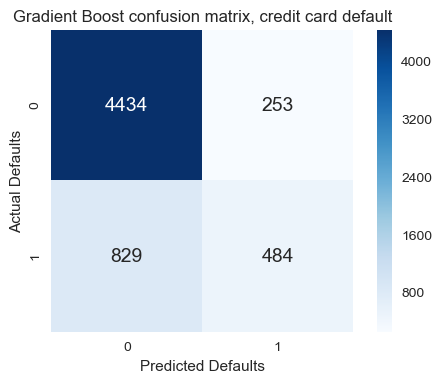

In [43]:
tn_GB,fp_GB,fn_GB,tp_GB,GB_confusion_matrix = get_confusion_matrix(y_test,y_pred_GB,n_defaults)

plt.rcParams.update({'font.size': 14})
plt.figure(dpi=100)
sns.heatmap(GB_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('Gradient Boost confusion matrix, credit card default');
plt.savefig('confusion_matrix_gb_n400.svg')

In [44]:
y_scores_GB1_threshold_0p3 = GB.predict_proba(X_test)[:, 1] > 0.3

#y_pred_GB1 = 
tn_GB1,fp_GB1,fn_GB1,tp_GB1,GB_confusion_matrix1 = get_confusion_matrix(y_test,y_scores_GB1_threshold_0p3,n_defaults)

True Negatives :  4072
False Positives:  615
False Negatives:  603
True Positives :  710 

Confusion matrix: 

 [[4072  615]
 [ 603  710]] 



In [45]:
#visualizer = DiscriminationThreshold(GB)

#plt.figure(figsize=(8,6));
#visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
                                        # Finalize and render the figure

In [46]:
#visualizer.show();

In [47]:
# I would like to get back the user ID
FP = X_test[(y_test == 0) & (y_pred_GB == 1)];
FN = X_test[(y_test == 1) & (y_pred_GB == 0)];
      
#print(FP);
#print(FN.shape);
#print(FP)
#TT = X_test(y_pred_GB == 1)

In [48]:
X_test
df[df['ID']==2309]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
2308,2309,30000,1,2,2,25,0,0,0,0,...,12580,13716,14828,1500,2000,1500,1500,1500,2000,0


In [49]:
y_pred_GB

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
X_test_raw.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
2308,30000,1,2,2,25,0,0,0,0,0,...,11581,12580,13716,14828,1500,2000,1500,1500,1500,2000
22404,150000,2,1,2,26,0,0,0,0,0,...,116684,101581,77741,77264,4486,4235,3161,2647,2669,2669
23397,70000,2,3,1,32,0,0,0,0,0,...,68530,69753,70111,70212,2431,3112,3000,2438,2500,2554
25058,130000,1,3,2,49,0,0,0,0,0,...,16172,16898,11236,6944,1610,1808,7014,27,7011,4408
2664,50000,2,2,2,36,0,0,0,0,0,...,42361,19574,20295,19439,2000,1500,1000,1800,0,1000


In [51]:
#X_test_raw(y_pred_GB==1)

# ->X_test_raw[ (y_test == 1) & (y_pred_GB == 0)].describe()


In [52]:
# -->>>>X_test_raw.describe()

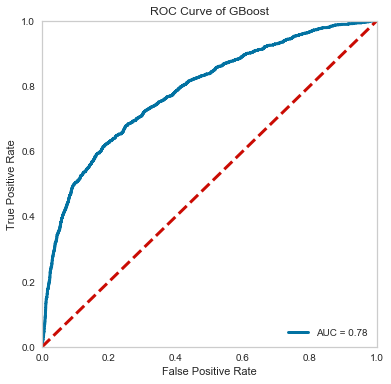

In [53]:

# Plot ROC curves and what not
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_GB, tpr_GB, 'b', label = 'AUC = %0.2f' % roc_auc_GB,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of GBoost');
plt.grid();
plt.savefig('roc_curve_gb.svg');
#plt.show();

In [93]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

interactive(lambda threshold: make_confusion_matrix(GB, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

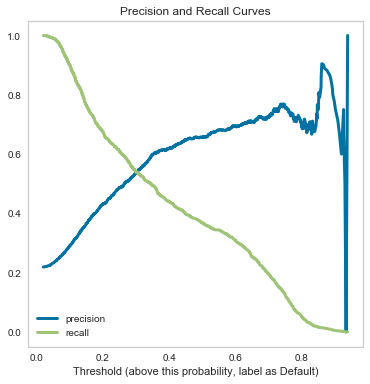

In [57]:
# ROC curve
prc_curve_gb, rec_curve_gb, thr_curve_gb = precision_recall_curve(y_test, y_scores_GB[:,1])

plt.figure(figsize=(6,6));
plt.plot(thr_curve_gb, prc_curve_gb[1:], label='precision', lw = 3)
plt.plot(thr_curve_gb, rec_curve_gb[1:], label='recall', lw = 3)
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Default)');
plt.title('Precision and Recall Curves');
plt.grid();


In [99]:
plt.figure(figsize=(6,6));
plt.plot(rec_curve_xgb[1:], prc_curve_xgb[1:],label='precision',lw=3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");
plt.grid();

NameError: name 'rec_curve_xgb' is not defined

<Figure size 432x432 with 0 Axes>

##### Profit/Loss Estimate

In [59]:
# Lets loop through multiple thresholds to get all possible combinations of 

thresholds = np.linspace(0,1,201)

#print(list_thresholds)

tnr = []
fpr = []
fnr = []
tpr = []

for i_thr in thresholds:
    
    y_pred_GB_thr = GB.predict_proba(X_test)[:, 1] > i_thr;
    
    itn,ifp,ifn,itp,iGB_confusion_matrix = get_confusion_matrix_no_print(y_test,y_pred_GB_thr);
    
    tnr.append(itn);
    fpr.append(ifp);
    fnr.append(ifn);
    tpr.append(itp);

#print(tnr)

In [95]:
# Let's make an assumption on the cost estimates
cost_per_TN =   six_month_rev_apr    # Rounded-up monthly_rev_apr
cost_per_FP =  -six_month_rev_apr
cost_per_FN =  -avg_default_loss   # Rounded-up from avg_default_loss
cost_per_TP =   0

net_revenue = []

for i in range(0,len(tpr)):
    
    temp = cost_per_TN*tnr[i] + cost_per_FP*fpr[i] + cost_per_FN*fnr[i] + cost_per_TP*tpr[i]
    
    net_revenue.append(float(temp))

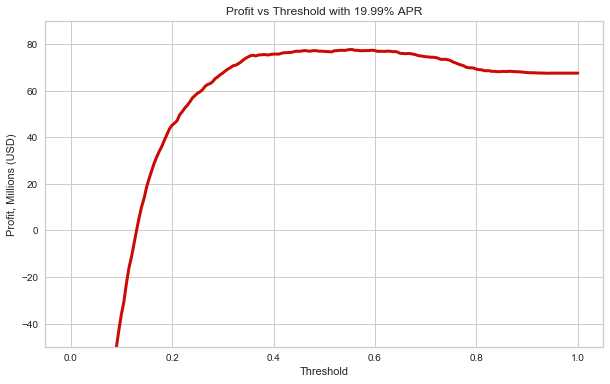

In [96]:
# Loss Curve
plt.figure(figsize=(10,6));
plt.rcParams.update({'font.size': 16})
plt.plot(thresholds, (np.asarray(net_revenue)/1.e6), 'r', lw = 3)
#plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.ylabel('Profit, Millions (USD)');
plt.title('Profit vs Threshold with 19.99% APR');
plt.savefig('revenue_estimate_based_threshold_GB.svg');
plt.ylim(-50, 90);
#plt.grid();

In [97]:
# From the above plot, use threshold of 0.051 as optimum

maximum_net_revenue_GB = max(net_revenue)

print ("Minimum profit: ${:12,.2f}".format(maximum_net_revenue_GB))
#print(maximum_net_revenue_GB)

max_index = net_revenue.index(max(net_revenue))

print('Threshold max:', thresholds[max_index])

Minimum profit: $77,599,699.05
Threshold max: 0.555


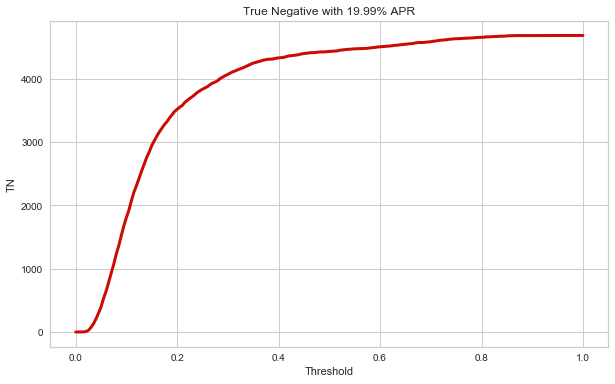

In [98]:
# TN Curve
plt.figure(figsize=(10,6));
plt.rcParams.update({'font.size': 16})
plt.plot(thresholds, (np.asarray(tnr)/1.), 'r', lw = 3)
#plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.ylabel('TN');
plt.title('True Negative with 19.99% APR');
plt.savefig('TN_based_threshold_GB.svg');
#plt.ylim(-40, 0)
#plt.grid();

In [ ]:
# Not an important section. I was trying to test and get exact numbers 
y_pred_GB_thr1 = GB.predict_proba(X_test)[:, 1] >= 0.3;

itn1,ifp1,ifn1,itp1,iGB_confusion_matrix1 = get_confusion_matrix_no_print(y_test,y_pred_GB_thr1);

print(iGB_confusion_matrix1)

df_TP = X_test_raw[ (y_test == 1) & (y_pred_GB_thr1 == 1) ]
df_FP = X_test_raw[ (y_test == 0) & (y_pred_GB_thr1 == 1) ]
df_FN = X_test_raw[ (y_test == 1) & (y_pred_GB_thr1 == 0) ]
df_TN = X_test_raw[ (y_test == 0) & (y_pred_GB_thr1 == 0) ]


# Get total amount of losses due to defaults
df_def_bill_amnt_TP = df_TP[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
df_def_bill_amnt_FP = df_FP[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
df_def_bill_amnt_FN = df_FN[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]
df_def_bill_amnt_TN = df_TN[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]

list_bill_def_amt_TP = df_def_bill_amnt_TP.values.tolist()
list_bill_def_amt_FP = df_def_bill_amnt_FP.values.tolist()
list_bill_def_amt_FN = df_def_bill_amnt_FN.values.tolist()
list_bill_def_amt_TN = df_def_bill_amnt_TN.values.tolist()

# We want to the last bill balance that was not paid
def_amnt_TP = []
def_amnt_FP = []
def_amnt_FN = []
def_amnt_TN = []

#counter_TP = 0

# True Positive
for i_list_bill_TP in list_bill_def_amt_TP:
    
    #counter_TP = counter_TP + 1
        
    if (i_list_bill_TP.count(0) < 6):
        imax = np.max(np.nonzero(i_list_bill_TP))
        def_amnt_TP.append(i_list_bill_TP[imax])
    else:
        def_amnt_TP.append(0)


# False Positive
for i_list_bill_FP in list_bill_def_amt_FP:
    
    #counter_TP = counter_TP + 1
        
    '''if (i_list_bill_FP.count(0) < 6):
        imax = np.max(np.nonzero(i_list_bill_FP))
        def_amnt_FP.append(i_list_bill_FP[imax])
    else:
        def_amnt_FP.append(0)'''
        
    temp_sum_FP = sum(i_list_bill_FP)
    
    def_amnt_FP.append(temp_sum_FP)
        

# False Negative
for i_list_bill_FN in list_bill_def_amt_FN:
    
    #counter_TP = counter_TP + 1
        
    if (i_list_bill_FN.count(0) < 6):
        imax = np.max(np.nonzero(i_list_bill_FN))
        def_amnt_FN.append(i_list_bill_FN[imax])
    else:
        def_amnt_FN.append(0)

        
# True Negative
for i_list_bill_TN in list_bill_def_amt_TN:
    
    #counter_TP = counter_TP + 1
        
    #if (i_list_bill_TN.count(0) < 6):
    #    imax = np.max(np.nonzero(i_list_bill_TN))
    #    def_amnt_TN.append(i_list_bill_TN[imax])
    #else:
    #    def_amnt_TN.append(0)
        
    temp_sum_TN = sum(i_list_bill_TN)
    
    def_amnt_TN.append(temp_sum_TN)
        
#print(len(def_amnt))
#print(sum(def_amnt))

total_def_amnt_TP = sum(def_amnt_TP)
total_def_amnt_FP = sum(def_amnt_FP)
total_def_amnt_FN = sum(def_amnt_FN)
total_def_amnt_TN = sum(def_amnt_TN)

# Default (TP)
print ("Total losses of defaults: ${:12,.2f}".format(total_def_amnt_TP))

avg_default_loss1 = float(total_def_amnt_TP)/float(len(def_amnt_TP))

print ("Average Default per Person: ${:12,.2f}".format(avg_default_loss1))


# No Default (TN)
print ("Total gains of defaults: ${:12,.2f}".format(total_def_amnt_TN))

avg_default_gain1 = float(total_def_amnt_TN*monthly_APR)/float(len(def_amnt_TN))

print ("Average Default per Person: ${:12,.2f}".format(avg_default_gain1))



cost_per_TP1 = 0;
cost_per_FP1 = -avg_default_gain1;
cost_per_FN1 = -avg_default_loss1;
cost_per_TN1 =  avg_default_gain1;

#cost_per_TP1  = avg_default_loss1
#cost_per_FN1  = avg_default_loss1

COST = cost_per_TN1*itn1 + cost_per_FP1*ifp1 + cost_per_FN1*ifn1 + cost_per_TP1*itp1

print ("COST: ${:12,.2f}".format(COST))

#### XGBoost Classifier

In [85]:
# See if we can find an optimum value of estimators
# Cross Validation Loop
s_estimators = 100;
e_estimators = 500;
n_incr = 50

N_range = np.arange(s_estimators,e_estimators+1,n_incr)

#print(N_range)
    
#C_range = np.linspace(0.0)
XGB_scores = []

for i in N_range:
    XGB = XGBClassifier(max_depth=3,n_estimators=i,n_jobs=-1);
    scores = cross_val_score(XGB, X_train, y_train, cv=cv_value, scoring='roc_auc');
    #print('auc_score')
    XGB_scores.append(scores.mean());
    
print(XGB_scores)
    
#print(k_scores)

[0.7800917572701184, 0.7799949638639857, 0.7797857323530387, 0.7786808240294444, 0.7774896615951051, 0.7770856902300751, 0.7758490889915184, 0.7750275316671523, 0.7742590988037391]


In [86]:
XGB = XGBClassifier(max_depth=3,n_estimators=500,n_jobs=-1);

XGB.fit(X_train, y_train);

In [87]:
print("XGBoost score, Train set: {:6.2f}%".format(100*XGB.score(X_train,y_train)))
print("XGBoost score, Test set : {:6.2f}%".format(100*XGB.score(X_test, y_test)))

XGBoost score, Train set:  83.52%
XGBoost score, Test set :  81.88%


In [88]:
y_pred_XGB   = XGB.predict(X_test)

y_scores_XGB = XGB.predict_proba(X_test)

fpr_XGB, tpr_XGB, threshold_XGB = roc_curve(y_test, y_scores_XGB[:, 1])

roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

print(roc_auc_XGB)

0.7800216638492722


True Negatives :  4441
False Positives:  246
False Negatives:  841
True Positives :  472 

Confusion matrix: 

 [[4441  246]
 [ 841  472]] 



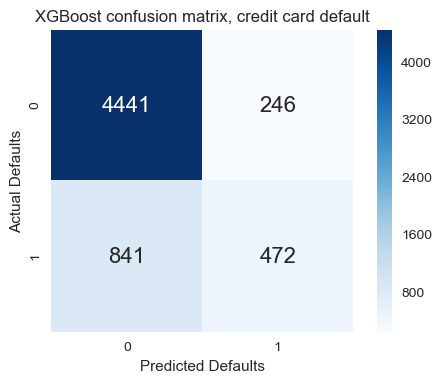

In [89]:
tn_XGB,fp_XGB,fn_XGB,tp_XGB,XGB_confusion_matrix = get_confusion_matrix(y_test,y_pred_XGB,n_defaults)

plt.figure(dpi=100)
sns.heatmap(XGB_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('XGBoost confusion matrix, credit card default');
plt.savefig('confusion_matrix_xgb_n400.svg')

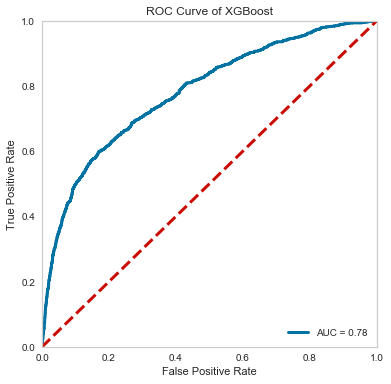

In [90]:
# Plot ROC curves and what not
plt.figure(figsize=(6,6));
plt.title('Receiver Operating Characteristic');
plt.plot(fpr_XGB, tpr_XGB, 'b', label = 'AUC = %0.2f' % roc_auc_XGB,lw=3);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--',lw=3);
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC Curve of XGBoost');
plt.grid();
plt.savefig('roc_curve_xgb.svg');
#plt.show();

In [91]:
# This block is taken from the notebook "classification_error_metrics_slns"
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['0', '1'],
           yticklabels=['0', '1']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

In [92]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(XGB, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
# ROC curve
prc_curve_xgb, rec_curve_xgb, thr_curve_xgb = precision_recall_curve(y_test, y_scores_XGB[:,1])

plt.figure(figsize=(10,8));
plt.plot(thr_curve_xgb, prc_curve_xgb[1:], label='precision', lw = 3)
plt.plot(thr_curve_xgb, rec_curve_xgb[1:], label='recall', lw = 3)
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Default)');
plt.title('Precision and Recall Curves');
plt.grid();


In [ ]:
plt.figure(figsize=(10,8));
plt.plot(rec_curve_xgb[1:], prc_curve_xgb[1:],label='precision',lw=3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");
plt.grid();

### Addressing Class Imbalance

#### Random Over-Sampling

In [ ]:
# It is apparent that so far all of the classifiers we have tried have not worked very well.
# One way is over-sample our minority class

ros = RandomOverSampler(random_state=random_seed)

X_train_resampled, y_train_resampled = ros.fit_sample(X_train,y_train)

# Yay, balanced classes!
Counter(y_train_resampled)

##### K-NN RoS

In [ ]:
# Let's retrain it again with classifier
knn30_ros = knn30.fit(X_train_resampled, y_train_resampled)

y_pred_knn30_ros = knn30_ros.predict(X_test)

y_scores_knn30_ros = knn30_ros.predict_proba(X_test)

fpr_knn30_ros, tpr_knn30_ros, threshold_knn30_ros = roc_curve(y_test, y_scores_knn30_ros[:, 1])

roc_auc_knn30_ros = auc(fpr_knn30_ros, tpr_knn30_ros)

print(roc_auc_knn30_ros)

In [ ]:
tn_knn30_ros,fp_knn30_ros,fn_knn30_ros,tp_knn30_ros,knn30_ros_confusion_matrix = \
                                        get_confusion_matrix(y_test,y_pred_knn30_ros,n_defaults)

plt.figure(dpi=100)
sns.heatmap(knn30_ros_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('kNN confusion matrix, ROS, credit card default');
plt.savefig('confusion_matrix_knn30_ros.svg')

In [ ]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(knn30_ros, threshold), threshold=(0.0,1.0,0.01))

##### Random Forest RoS

In [ ]:
rf_ros = randomforest.fit(X_train_resampled,y_train_resampled)

y_pred_rf_ros = rf_ros.predict(X_test)

y_scores_rf_ros = rf_ros.predict_proba(X_test)

fpr_rf_ros, tpr_rf_ros, threshold_rf_ros = roc_curve(y_test, y_scores_rf_ros[:, 1])

roc_auc_rf_ros = auc(fpr_rf_ros, tpr_rf_ros)

f1_score_rf_ros = f1_score(y_test,y_pred_rf_ros)
recall_score_rf_ros = recall_score(y_test,y_pred_rf_ros)

print(roc_auc_rf_ros)
print(f1_score_rf_ros)
print(recall_score_rf_ros)


In [ ]:
tn_rf_ros,fp_rf_ros,fn_rf_ros,tp_rf_ros,rf_ros_confusion_matrix = \
                                        get_confusion_matrix(y_test,y_pred_rf_ros,n_defaults)

plt.figure(dpi=100)
sns.heatmap(rf_ros_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('RF confusion matrix, ROS, credit card default');
plt.savefig('confusion_matrix_rf_ros.svg')

#### SMOTE

In [ ]:
#X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

smote = SMOTE(random_state=random_seed)

X_train_smoted, y_train_smoted = smote.fit_sample(X_train,y_train)

# Yay, balanced classes!
Counter(y_train_smoted)

##### k-NN SMOTE

In [ ]:
# Let's retrain it again with classifier
knn30_smote = knn30.fit(X_train_smoted, y_train_smoted)

y_pred_knn30_smote = knn30_smote.predict(X_test)

y_scores_knn30_smote = knn30_smote.predict_proba(X_test)

fpr_knn30_smote, tpr_knn30_smote, threshold_knn30_smote = roc_curve(y_test, y_scores_knn30_smote[:, 1])

roc_auc_knn30_smote = auc(fpr_knn30_smote, tpr_knn30_smote)

f1_score_knn30_smote = f1_score(y_test, y_pred_knn30_smote)
recall_score_knn30_smote = recall_score(y_test, y_pred_knn30_smote)

print(roc_auc_knn30_smote)
print(f1_score_knn30_smote)
print(recall_score_knn30_smote)

In [ ]:
tn_knn30_smote,fp_knn30_smote,fn_knn30_smote,tp_knn30_smote,knn30_smote_confusion_matrix = \
                                        get_confusion_matrix(y_test,y_pred_knn30_smote,n_defaults)

plt.figure(dpi=100)
sns.heatmap(knn30_smote_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('knn confusion matrix, SMOTE, credit card default');
plt.savefig('confusion_matrix_knn30_smote.svg')

#### ADASYN

In [ ]:
adasyn = ADASYN(random_state=random_seed)

X_train_adasyn, y_train_adasyn = adasyn.fit_sample(X_train,y_train)

Counter(y_train_adasyn)

##### k-NN ADASYN

In [ ]:
# Let's retrain it again with classifier
knn30_adasyn = knn30.fit(X_train_adasyn, y_train_adasyn)

y_pred_knn30_adasyn = knn30_adasyn.predict(X_test)

y_scores_knn30_adasyn = knn30_adasyn.predict_proba(X_test)

fpr_knn30_adasyn, tpr_knn30_adasyn, threshold_knn30_adasyn = roc_curve(y_test, y_scores_knn30_adasyn[:, 1])

roc_auc_knn30_adasyn = auc(fpr_knn30_adasyn, tpr_knn30_adasyn)

f1_score_knn30_adasyn     = f1_score(y_test, y_pred_knn30_adasyn)
recall_score_knn30_adasyn = recall_score(y_test, y_pred_knn30_adasyn)

print(roc_auc_knn30_adasyn)
print(f1_score_knn30_adasyn)
print(recall_score_knn30_adasyn)

In [ ]:
tn_knn30_adasyn,fp_knn30_adasyn,fn_knn30_adasyn,tp_knn30_adasyn,knn30_adasyn_confusion_matrix = \
                                        get_confusion_matrix(y_test,y_pred_knn30_adasyn,n_defaults)

plt.figure(dpi=100)
sns.heatmap(knn30_adasyn_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('knn confusion matrix, ADASYN, credit card default');
plt.savefig('confusion_matrix_knn30_adasyn.svg')

##### SVC ADASYN

In [ ]:
# Let's retrain it again with classifier. Using SVC but remove C=1
svc3n = svm.SVC(kernel='rbf',probability=True);
svc3n.fit(X_train,y_train);

print("SVC-RBF score, Train set: {:6.2f}%".format(100*svc3n.score(X_train,y_train)))
print("SVC-RBF score, Test set : {:6.2f}%".format(100*svc3n.score(X_test, y_test)))

svc3_adasyn = svc3n.fit(X_train_adasyn, y_train_adasyn)

In [ ]:
y_pred_svc3_adasyn = svc3_adasyn.predict(X_test)

y_scores_svc3_adasyn = svc3_adasyn.predict_proba(X_test)

fpr_svc3_adasyn, tpr_svc3_adasyn, threshold_svc3_adasyn = roc_curve(y_test, y_scores_svc3_adasyn[:, 1])

roc_auc_svc3_adasyn = auc(fpr_svc3_adasyn, tpr_svc3_adasyn)

f1_score_svc3_adasyn     = f1_score(y_test,     y_pred_svc3_adasyn)
recall_score_svc3_adasyn = recall_score(y_test, y_pred_svc3_adasyn)

print(roc_auc_svc3_adasyn)
print(f1_score_svc3_adasyn)
print(recall_score_svc3_adasyn)

In [ ]:
tn_svc3n_adasyn,fp_svc3n_adasyn,fn_svc3n_adasyn,tp_svc3n_adasyn,svc3n_adasyn_confusion_matrix = \
                                        get_confusion_matrix(y_test,y_pred_svc3_adasyn,n_defaults)

plt.figure(dpi=100)
sns.heatmap(svc3n_adasyn_confusion_matrix, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1],fmt='g')

plt.xlabel('Predicted Defaults')
plt.ylabel('Actual Defaults')
plt.title('SVC confusion matrix, ADASYN, credit card default');
plt.savefig('confusion_matrix_svc3n_adasyn.svg')

### ROC AUC Scores for All Models

In [ ]:
# Create a Pandas Data frame
Classifier = ['kNN','Log. Reg.','NB: Gaussian','NB: Bernoulli','R. Forest',
              'Extra Trees','SVC-RBF','ADABoost-RF','CatBoost','GradBoost','XGB']

roc_auc_scores = [roc_auc30,roc_auc_logres1,roc_auc_gnb,roc_auc_bnb,roc_auc_rf,roc_auc_etc,
                  roc_auc_svc3,roc_auc_abc,roc_auc_cat,roc_auc_GB,roc_auc_XGB]

df_source = pd.DataFrame({
    'Classifier': Classifier,
    'AUC': roc_auc_scores
})

df_source

In [ ]:
plt.figure(figsize=(15,6));
plt.bar(Classifier,roc_auc_scores);
plt.title('AUC for Models Used, Credit Card Default');
plt.xlabel('Classifiers');
plt.ylabel('AUC');
plt.ylim([0.0,1])
plt.savefig('auc_all_models.svg');
#plt.grid();